In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# be careful with that:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data

data_heatmap = pd.read_csv('../datasets/A_data_heatmap_300x250_3p.csv')
data_metrics = pd.read_csv('../datasets/A_data_domain_perf_metrics_300x250_3p.csv')

In [67]:
data_metrics

,Unnamed: 0,domain,grid_id,webview_height,webview_width,displays,clicks,landed_clicks,non_bounced_clicks,closing_events,avg_last_second_framerate,sov_short_ttc,sov_short_ttc_global,sov_short_ttc_score
0,0,ID_1815,333519,250.0,300.0,2832,11.0,6.0,3.0,7.0,60.578947,0.002750,0.049334,-0.046584
1,1,ID_979,333519,250.0,300.0,2169,1.0,1.0,1.0,NaN,59.000000,NaN,NaN,NaN
2,2,ID_1413,333519,250.0,300.0,7077,16.0,2.0,0.0,5.0,31.333333,0.345627,0.185044,0.292426
3,3,ID_1408,333519,250.0,300.0,14106,22.0,17.0,2.0,NaN,56.500000,NaN,NaN,NaN
4,4,ID_1196,333519,250.0,300.0,2688,1.0,1.0,1.0,NaN,55.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5501,5501,ID_2786,333346,250.0,300.0,5691,6.0,6.0,5.0,3.0,60.583333,NaN,NaN,NaN
5502,5502,ID_2974,333346,250.0,300.0,152352,27.0,23.0,9.0,NaN,71.489362,0.012835,0.049334,-0.036499
5503,5503,ID_385,333346,250.0,300.0,96687,42.0,33.0,12.0,1.0,66.844444,0.010152,0.053200,-0.039182
5504,5504,ID_3557,333346,250.0,300.0,1011320,475.0,405.0,263.0,48.0,73.767480,0.069024,0.053200,0.019690


In [3]:
# expand so that each row corresponds to 1 click:

data_heatmap_expanded = data_heatmap.loc[data_heatmap.index.repeat(data_heatmap['clicks'])].reset_index(drop=True)
data_heatmap_expanded['clicks'] = 1

click_stat = data_heatmap_expanded.groupby(['click_x','click_y'])['clicks'].count().reset_index()

In [4]:
data_heatmap

,Unnamed: 0,domain,grid_id,click_x,click_y,display_height,display_width,clicks
0,0,ID_1763,333519,179,4,250,300,1
1,1,ID_1763,333519,262,185,250,300,1
2,2,ID_1763,333519,122,188,250,300,1
3,3,ID_1763,333519,263,197,250,300,1
4,4,ID_1763,333519,242,159,250,300,1
...,...,...,...,...,...,...,...,...
1935421,1935421,ID_1501,333519,163,145,250,300,8
1935422,1935422,ID_1501,333519,41,139,250,300,4
1935423,1935423,ID_1501,333519,213,97,250,300,2
1935424,1935424,ID_1501,333519,271,245,250,300,1


In [5]:
# Binning clicks in nr_of_x_bins, nr_of_y_bins:

NR_OF_X_BINS = 61
NR_OF_Y_BINS = 51

max_width = data_heatmap['display_width'].max()
max_height = data_heatmap['display_height'].max()

width_bins = np.linspace(1, max_width, NR_OF_X_BINS)
height_bins = np.linspace(1, max_height, NR_OF_Y_BINS)

width_bins_max = len(width_bins)-2 # start at 0
height_bins_max = len(height_bins)-2

data_heatmap_expanded['click_x_bin'] = pd.cut(data_heatmap_expanded['click_x'], 
                                      bins = width_bins, 
                                      labels=False, 
                                      include_lowest=True)

data_heatmap_expanded['click_y_bin'] = pd.cut(data_heatmap_expanded['click_y'], 
                                      bins=height_bins, 
                                      labels=False, 
                                      include_lowest=True)


aggregated_clicks = data_heatmap_expanded.groupby(['grid_id',
                                           'domain', 
                                           'click_x_bin', 
                                           'click_y_bin']).size().reset_index(name='clicks_sum')


#aggregated_clicks['clicks_sum'].astype('int64');

In [6]:
aggregated_clicks

,grid_id,domain,click_x_bin,click_y_bin,clicks_sum
0,333346,ID_1,0,31,1
1,333346,ID_1,0,48,1
2,333346,ID_1,2,39,1
3,333346,ID_1,3,20,1
4,333346,ID_1,4,19,1
...,...,...,...,...,...
887218,333519,ID_999,58,34,1
887219,333519,ID_999,58,43,1
887220,333519,ID_999,58,46,1
887221,333519,ID_999,59,6,1


In [56]:
# add empty bins --> easier to generate vectors
# takes a few seconds

from itertools import product

domains_grids = data_heatmap[['domain', 'grid_id']].drop_duplicates()

aux = pd.DataFrame(list(product(range(0,width_bins_max+1), 
                                range(0,height_bins_max+1))), 
                   columns=['click_x_bin', 'click_y_bin'])

domains_grids['key'] = 1
aux['key'] = 1

expanded_set = pd.merge(domains_grids, aux, on='key').drop('key', axis=1)

data_binned = pd.merge(expanded_set, aggregated_clicks, 
                  on = ['domain', 'grid_id', 'click_x_bin', 'click_y_bin'], 
                  how = 'left').fillna(0)
data_binned['clicks_sum'] = data_binned['clicks_sum'].astype('int64')
# data_binned = data_binned[data_binned['grid_id'] == 333519]

In [57]:
data_binned['grid_id'].unique()

array([333519, 333346])

In [58]:

grid_id = 333346

data_binned = data_binned[data_binned['grid_id'] == grid_id]

# PCA code

In [59]:
# Assuming data_binned is your DataFrame
# Use pivot_table to create a wide-format DataFrame
pivot_df = pd.pivot_table(data_binned, values='clicks_sum', index=['domain', 'grid_id'],
                           columns=['click_x_bin', 'click_y_bin'], aggfunc='sum', fill_value=0)

# Reset index to make 'domain' and 'grid_id' regular columns
pivot_df.reset_index(inplace=True)

# Rename columns to match the desired format
pivot_df.columns = ['domain', 'grid_id'] + [f'clicks_sum_for_{x}_{y}' for x, y in pivot_df.columns[2:]]

# Display the resulting DataFrame
print(pivot_df)


      domain  grid_id  clicks_sum_for_0_0  clicks_sum_for_0_1  \
0       ID_1   333346                   0                   0   
1      ID_10   333346                  54                  36   
2    ID_1002   333346                   0                   0   
3    ID_1005   333346                   0                   0   
4    ID_1010   333346                   0                   0   
..       ...      ...                 ...                 ...   
856   ID_978   333346                   0                   0   
857   ID_989   333346                   0                   1   
858   ID_993   333346                   0                   0   
859   ID_996   333346                   0                   0   
860   ID_999   333346                   1                   1   

     clicks_sum_for_0_2  clicks_sum_for_0_3  clicks_sum_for_0_4  \
0                     0                   0                   0   
1                    12                   1                   1   
2                 

In [60]:
input = pivot_df.drop(['domain', 'grid_id'], axis=1)

# Move the index to the first column
input.reset_index(inplace=True)

# Display the resulting DataFrame

In [61]:
print(input)

     index  clicks_sum_for_0_0  clicks_sum_for_0_1  clicks_sum_for_0_2  \
0        0                   0                   0                   0   
1        1                  54                  36                  12   
2        2                   0                   0                   1   
3        3                   0                   0                   0   
4        4                   0                   0                   0   
..     ...                 ...                 ...                 ...   
856    856                   0                   0                   0   
857    857                   0                   1                   1   
858    858                   0                   0                   0   
859    859                   0                   0                   0   
860    860                   1                   1                   0   

     clicks_sum_for_0_3  clicks_sum_for_0_4  clicks_sum_for_0_5  \
0                     0                   0 

In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

features = input.columns[1:]  # Exclude the first column, which is the index

# Select the number of components (in this case, reduce to 2 dimensions)
n_components = 2

# Instantiate the PCA model
# pca = PCA(n_components=n_components)

pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=n_components))])


# Fit and transform the data
pca_result = pipeline.fit_transform(input[features])

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(n_components)])

# Concatenate the first column (index) from pca_input to pca_df
pca_df['index'] = input['index']

# Display the resulting DataFrame
print(pca_df)

           PC1       PC2  index
0    -7.659579  0.267174      0
1    -1.989115  1.967048      1
2    -6.420827  4.319276      2
3    10.462451 -3.300999      3
4    -9.490901  1.226616      4
..         ...       ...    ...
856  -7.806249  0.223414    856
857  -5.502313  0.243463    857
858  -9.092464  0.864551    858
859  -9.317000  2.085787    859
860  -7.852599  0.067881    860

[861 rows x 3 columns]


In [66]:
pca_result

array([[-7.65957864,  0.26717422],
       [-1.98911522,  1.96704843],
       [-6.4208274 ,  4.31927572],
       ...,
       [-9.09246447,  0.86455053],
       [-9.31700032,  2.08578706],
       [-7.85259854,  0.06788058]])

In [63]:
print(grid_id)

333346


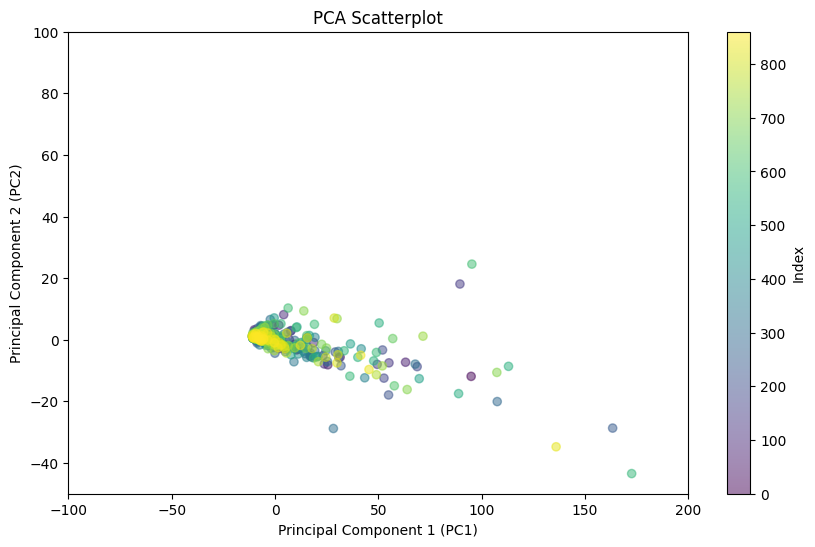

In [64]:
# Plotting pca_df
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['index'], cmap='viridis', alpha=0.5)
plt.title('PCA Scatterplot')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.colorbar(label='Index')

plt.xlim([-100, 200])
plt.ylim([-50, 100])

# plt.show()

plt.savefig(f'PCA_gridid_{grid_id}.jpg')

# CV code

In [ ]:
# aggregated clicks by grid_id:
aggregated_clicks['ID'] = aggregated_clicks['grid_id'].astype(str) + '_' + aggregated_clicks['domain'].astype(str)

In [ ]:
aggregated_clicks_ID = aggregated_clicks['ID'].unique()

In [ ]:
aggregated_clicks_ID

In [ ]:
for unique_ID in aggregated_clicks_ID:
    # unique_ID = '333346_ID_1'
    ex = aggregated_clicks[aggregated_clicks.ID == unique_ID]

    click_matrix = ex.pivot("click_y_bin","click_x_bin", "clicks_sum").fillna(0)

    plt.figure(figsize=(18, 16))
    sns.heatmap(click_matrix, 
                cmap = "YlGnBu", 
                annot = False, 
                cbar = True, 
                fmt = "g")

    plt.title(f'Click Heatmap for combined clicks in grid = {333519}')
    plt.xlabel('click_x Bin')
    plt.ylabel('click_y Bin')
    plt.gca().invert_yaxis() 
    #plt.savefig('hm_333519.png', bbox_inches='tight')
    plt.show()

    ex = aggregated_clicks[aggregated_clicks.ID == unique_ID]

    click_matrix = ex.pivot("click_y_bin","click_x_bin", "clicks_sum").fillna(0)

    plt.figure(figsize=(18, 16))
    sns.heatmap(click_matrix, 
                cmap = "YlGnBu", 
                annot = False, 
                cbar = True, 
                fmt = "g")

    plt.title(f'Click Heatmap for combined clicks in ID = {unique_ID}')
    plt.xlabel('click_x Bin')
    plt.ylabel('click_y Bin')
    plt.gca().invert_yaxis() 
    plt.savefig(f'../datasets/heatmaps/hm_{unique_ID}.png', bbox_inches='tight')
    # plt.show()

In [ ]:
# create aggregated heatmaps:

ex = aggregated_clicks_by_grid[aggregated_clicks_by_grid.grid_id == 333519]

click_matrix = ex.pivot("click_y_bin","click_x_bin", "clicks_sum").fillna(0)

plt.figure(figsize=(18, 16))
sns.heatmap(click_matrix, 
            cmap = "YlGnBu", 
            annot = False, 
            cbar = True, 
            fmt = "g")

plt.title(f'Click Heatmap for combined clicks in grid = {333519}')
plt.xlabel('click_x Bin')
plt.ylabel('click_y Bin')
plt.gca().invert_yaxis() 
#plt.savefig('hm_333519.png', bbox_inches='tight')
plt.show()

ex = aggregated_clicks_by_grid[aggregated_clicks_by_grid.grid_id == 333346]

click_matrix = ex.pivot("click_y_bin","click_x_bin", "clicks_sum").fillna(0)

plt.figure(figsize=(18, 16))
sns.heatmap(click_matrix, 
            cmap = "YlGnBu", 
            annot = False, 
            cbar = True, 
            fmt = "g")

plt.title(f'Click Heatmap for combined clicks in grid = {333346}')
plt.xlabel('click_x Bin')
plt.ylabel('click_y Bin')
plt.gca().invert_yaxis() 
#plt.savefig('hm_333519.png', bbox_inches='tight')
plt.show()

# Other code

In [ ]:
# for clustering

data_binned[(data_binned.domain == 'ID_1763') &
            (data_binned.grid_id == 333519)]['clicks_sum'].to_numpy()

In [ ]:
cl_stat = aggregated_clicks.groupby(['click_x_bin','click_y_bin']).count().reset_index()
cl_stat = cl_stat[['click_x_bin','click_y_bin','clicks_sum']]
cl_stat['bin_prob'] = cl_stat['clicks_sum']/cl_stat['clicks_sum'].sum()

In [ ]:
# aggregated clicks by grid_id:

aggregated_clicks_by_grid = aggregated_clicks.groupby([
                                'grid_id','click_x_bin','click_y_bin'
                            ]).sum('clicks_sum').reset_index()

In [ ]:
distinct_values_count = aggregated_clicks_by_grid.groupby('grid_id').nunique()
print(distinct_values_count)

------

# Some visualization

In [ ]:
aggregated_clicks_by_grid

In [ ]:
# create aggregated heatmaps:

ex = aggregated_clicks_by_grid[aggregated_clicks_by_grid.grid_id == 333519]

click_matrix = ex.pivot("click_y_bin","click_x_bin", "clicks_sum").fillna(0)

plt.figure(figsize=(18, 16))
sns.heatmap(click_matrix, 
            cmap = "YlGnBu", 
            annot = False, 
            cbar = True, 
            fmt = "g")

plt.title(f'Click Heatmap for combined clicks in grid = {333519}')
plt.xlabel('click_x Bin')
plt.ylabel('click_y Bin')
plt.gca().invert_yaxis() 
#plt.savefig('hm_333519.png', bbox_inches='tight')
plt.show()

ex = aggregated_clicks_by_grid[aggregated_clicks_by_grid.grid_id == 333346]

click_matrix = ex.pivot("click_y_bin","click_x_bin", "clicks_sum").fillna(0)

plt.figure(figsize=(18, 16))
sns.heatmap(click_matrix, 
            cmap = "YlGnBu", 
            annot = False, 
            cbar = True, 
            fmt = "g")

plt.title(f'Click Heatmap for combined clicks in grid = {333346}')
plt.xlabel('click_x Bin')
plt.ylabel('click_y Bin')
plt.gca().invert_yaxis() 
#plt.savefig('hm_333519.png', bbox_inches='tight')
plt.show()

In [ ]:
# Boxplots and histograms

x = aggregated_clicks.groupby(['domain','grid_id']).sum().reset_index()

data_333519 = x[x.grid_id == 333519]['clicks_sum']
data_333346 = x[x.grid_id == 333346]['clicks_sum']

plt.figure(figsize=(10, 6))
plt.boxplot([data_333519, data_333346], labels=['grid_id 333519', 'grid_id 333346'])
plt.title('Boxplot of Clicks Sum for grid_id 333519 and 333346')
plt.ylabel('Clicks Sum')
plt.grid(True)
#plt.savefig('bp.png', bbox_inches='tight')
plt.show()

data_333519 = x[(x.grid_id == 333519) & (x.clicks_sum <= 5000)]['clicks_sum']
data_333346 = x[(x.grid_id == 333346) & (x.clicks_sum <= 5000)]['clicks_sum']

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(data_333519, bins=30, color='blue', edgecolor='black')
plt.title('Histogram of Clicks Sum for grid_id 333519 (Excluding <= 5000)')
plt.xlabel('Clicks Sum')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  
plt.ticklabel_format(style='plain', axis='x') 
plt.locator_params(axis='x', nbins=24)  

plt.subplot(1, 2, 2)
plt.hist(data_333346, bins=30, color='green', edgecolor='black')
plt.title('Histogram of Clicks Sum for grid_id 333346 (Excluding <= 5000)')
plt.xlabel('Clicks Sum')
plt.ylabel('Frequency')
plt.xticks(rotation=45) 
plt.ticklabel_format(style='plain', axis='x')  
plt.locator_params(axis='x', nbins=24) 

plt.tight_layout()

#plt.savefig('histo.png', bbox_inches='tight')
plt.show()

g_333346_nr_ge1000 = len(x[(x.grid_id == 333346) & (x.clicks_sum > 1000)]['domain'].unique())
pct_333346_nr_ge1000 = g_333346_nr_ge1000/len(x[(x.grid_id == 333346)]['domain'].unique())
print(f'Nr of domains with grid_id {333346} and more than 1k clicks: {g_333346_nr_ge1000}')
print(f'Percentage of domains with grid_id {333346} and more than 1k clicks: {pct_333346_nr_ge1000:.2f}')

g_333519_nr_ge1000 = len(x[(x.grid_id == 333519) & (x.clicks_sum > 1000)]['domain'].unique())
pct_333519_nr_ge1000 = g_333519_nr_ge1000/len(x[(x.grid_id == 333519)]['domain'].unique())
print(f'Nr of domains with grid_id {333519} and more than 1k clicks: {g_333519_nr_ge1000}')
print(f'Percentage of domains with grid_id {333519} and more than 1k clicks: {pct_333519_nr_ge1000:.2f}')

In [ ]:
# example of broken banners (pretty sure) for grid_id = 333519:

some_broken = {'ID_1246', 'ID_1305', 'ID_1353', 'ID_1448', 'ID_1522', 'ID_1544', 
               'ID_162',  'ID_1671', 'ID_1682', 'ID_1690', 'ID_1824', 'ID_1888', 'ID_1929', 
               'ID_2097', 'ID_2249', 'ID_2268', 'ID_2339', 'ID_2396', 'ID_2438', 
               'ID_2609', 'ID_2863', 'ID_2908', 'ID_3061', 'ID_3420', 'ID_3470', 'ID_962'}

some_broken_list = list(some_broken)

n_rows, n_cols = 3, 2  # 3x2 layout
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))  # Adjust the figure size as needed
fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust spacing between plots

plot_count = 0
total_plots = len(some_broken_list)

for idx, br in enumerate(some_broken_list):
    GRID_ID = 333519
    ID = br
#    print(br)
    ex = aggregated_clicks[(aggregated_clicks.grid_id == GRID_ID) &
                           (aggregated_clicks.domain == ID)]

    click_matrix = ex.pivot("click_y_bin", "click_x_bin", "clicks_sum").fillna(0)
    
    if plot_count == n_rows * n_cols:  # Check if the figure is full
        #plt.savefig(f'heatmap_combined_{idx}.png', bbox_inches='tight')  # Save current figure
        plt.show()
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))  # Start a new figure
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        plot_count = 0  # Reset plot count for the new figure

    row = plot_count // n_cols
    col = plot_count % n_cols
    
    ax = axes[row, col]
    sns.heatmap(click_matrix, 
                cmap="YlGnBu", 
                annot=False, 
                cbar=True, 
                fmt="g", 
                ax=ax)
    ax.set_title(f'Click Heatmap for grid = {GRID_ID} and domain = {ID}')
    ax.set_xlabel('click_x Bin')
    ax.set_ylabel('click_y Bin')
    ax.invert_yaxis()
    
    plot_count += 1

if plot_count > 0:
#    plt.savefig(f'heatmap_combined_final.png', bbox_inches='tight')
    plt.show()



In [ ]:
x = data_heatmap_expanded[(data_heatmap_expanded.grid_id == 333519) & 
                          (data_heatmap_expanded.domain == 'ID_1501')]
heatmap_data, xedges, yedges = np.histogram2d(x['click_x'], x['click_y'], 
                                              bins=[50, 50])

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data.T, cmap='YlGnBu', cbar=True)
plt.title(f'Heatmap for ID_1501')
plt.xlabel('click_x')
plt.ylabel('click_y')
plt.gca().invert_yaxis() # Invert y-axis to match the coordinate system
plt.show()

In [ ]:
unique_domains = aggregated_clicks['domain'].unique()

for domain in unique_domains[:3]:
    domain_data = aggregated_clicks[(aggregated_clicks.grid_id == 333346) & 
                                    (aggregated_clicks['domain'] == domain)]
    
    click_matrix = domain_data.pivot("click_y_bin", "click_x_bin", "clicks_sum").fillna(0)
    tot_clicks = domain_data['clicks_sum'].sum()
    print(f'Total number of clicks for domain = {domain} and grid = {333346}: {tot_clicks}')
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(click_matrix, cmap="YlGnBu", annot=True, cbar=True, fmt="g")
    plt.title(f'Click Heatmap for {domain}')
    plt.xlabel('click_x Bin')
    plt.ylabel('click_y Bin')
    plt.gca().invert_yaxis()  # Adjust to match the coordinate system orientation if necessary
    plt.show()

In [ ]:
data_heatmap_expanded = data_heatmap.loc[
                                         data_heatmap.index.repeat(data_heatmap['clicks'])
                                        ].reset_index(drop=True)

x = data_heatmap_expanded[(data_heatmap_expanded.grid_id == 333346) & 
                          (data_heatmap_expanded.domain == 'ID_1062')]

heatmap_data, xedges, yedges = np.histogram2d(x['click_x'], x['click_y'], 
                                              bins=[50, 50])

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data.T, cmap='YlGnBu', cbar=True)
plt.title(f'Heatmap for ID_1062')
plt.xlabel('click_x')
plt.ylabel('click_y')
plt.gca().invert_yaxis() 
plt.show()

# Some Bootstrap functions

In [ ]:
# def weighted_bootstrap_resample(data, weights, n_bootstraps=1000):
#     boot_means = []
#     for _ in range(n_bootstraps):
#         indices = np.random.choice(data.index, 
#                                    size=len(data), 
#                                    replace=True, 
#                                    p=weights)
#         boot_sample = data.loc[indices]
#         boot_means.append(np.mean(boot_sample['clicks_sum']))
#     return np.mean(boot_means), np.percentile(boot_means, [2.5, 97.5])

def weighted_bootstrap_resample(data, drawing_distro, emp_distro, size, n_bootstraps=1000):
    tot_log_proba = 0
    for _ in range(n_bootstraps):
        indices = np.random.choice(data.index, 
                                   size=size, 
                                   replace=True, 
                                   p=data[drawing_distro])
        log_proba = np.log(data.loc[indices][emp_distro]).sum()
        tot_log_proba += log_proba
    return tot_log_proba/n_bootstraps #boots[['click_x_bin','click_y_bin', 'boot']]

## Chi-Squared:

In [ ]:
from scipy.stats import chisquare

def Chi_squared_test(aggregated_clicks, aggregated_clicks_by_grid, ID, GRID_ID):
    observed = aggregated_clicks[(aggregated_clicks.grid_id == GRID_ID) &
                                 (aggregated_clicks.domain == ID)]

    click_stat_grid = aggregated_clicks_by_grid[aggregated_clicks_by_grid.grid_id == GRID_ID]
    click_stat_grid = click_stat_grid.copy()
    click_stat_grid['bin_prob'] = click_stat_grid['clicks_sum']/click_stat_grid['clicks_sum'].sum()

    observed_freq = observed.merge(click_stat_grid, 
                                   on=['click_x_bin',
                                       'click_y_bin'], 
                                   how='right').fillna(0)

    observed_freq = observed[['click_x_bin',
                              'click_y_bin',
                              'clicks_sum']].merge(click_stat_grid[['click_x_bin',
                                                    'click_y_bin',
                                                    'bin_prob']], 
                                   on=['click_x_bin',
                                       'click_y_bin'], 
                                   how='right').fillna(0)

    total_observations = observed_freq['clicks_sum'].sum()
    observed_freq['Expected'] = observed_freq['bin_prob'] * total_observations

    # Perform Chi-square test
    chi_square_stat, p_value = chisquare(f_obs = observed_freq['clicks_sum'], 
                                         f_exp = observed_freq['Expected'])
    
    return chi_square_stat, p_value, total_observations

# Data enhancement

In [ ]:
def enhance_data_with_noise(data, prob, size, sdev):
    indices = np.random.choice(data.index, 
                                   size, 
                                   replace=True, 
                                   p = data[prob])
    
    pert_x = np.random.normal(0, sdev, size).round().astype(int)
    pert_y = np.random.normal(0, sdev, size).round().astype(int)

    x = data.loc[indices][['click_x_bin', 'click_y_bin']] + np.array((pert_x, pert_y)).reshape(-1,2)
    x_bin_max = data['click_x_bin'].max()
    y_bin_max = data['click_y_bin'].max()
    
    x[x['click_x_bin'] < 0]['click_x_bin'] = 0
    x[x['click_y_bin'] < 0]['click_y_bin'] = 0
    x[x['click_x_bin'] > x_bin_max]['click_x_bin'] = x_bin_max
    x[x['click_y_bin'] > y_bin_max]['click_y_bin'] = y_bin_max
    
    x = x.groupby(['click_x_bin','click_y_bin']).size().reset_index(name = 'clicks_sum')

    tt = pd.DataFrame(list(product(range(0,x_bin_max+1), range(0,y_bin_max+1))), 
                      columns=['click_x_bin', 'click_y_bin'])

    data_obs_merged = tt.merge(x, on = ['click_x_bin','click_y_bin'], how = 'left').fillna(0)
#    data_obs_merged['boots_clicks'].sum()
    return data_obs_merged

In [ ]:
# example

GRID_ID = 333519
ID = 'ID_2268'

data_obs = aggregated_clicks[(aggregated_clicks.grid_id == GRID_ID) &
                             (aggregated_clicks.domain == ID)]

data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()


ex = enhance_data_with_noise(data_obs, 'proba', 5000, 2)

click_matrix = ex.pivot("click_y_bin","click_x_bin", "clicks_sum").fillna(0)

plt.figure(figsize=(8, 6))

sns.heatmap(click_matrix, 
            cmap = "YlGnBu", 
            annot = False, 
            cbar = True, 
            fmt = "g")

plt.title(f'Click Heatmap for clicks in grid = {GRID_ID} and domain = {ID}')
plt.xlabel('click_x Bin')
plt.ylabel('click_y Bin')
plt.gca().invert_yaxis() 
#plt.savefig(f'hm_{ID}_{GRID_ID}.png', bbox_inches='tight')
plt.show()

ex = data_obs
click_matrix = ex.pivot("click_y_bin","click_x_bin", "clicks_sum").fillna(0)

plt.figure(figsize=(8, 6))

sns.heatmap(click_matrix, 
            cmap = "YlGnBu", 
            annot = False, 
            cbar = True, 
            fmt = "g")

plt.title(f'Click Heatmap for clicks in grid = {GRID_ID} and domain = {ID}')
plt.xlabel('click_x Bin')
plt.ylabel('click_y Bin')
plt.gca().invert_yaxis() 
#plt.savefig(f'hm_{ID}_{GRID_ID}.png', bbox_inches='tight')
plt.show()

In [ ]:
# chi squared test function with noise enhancement:

def Chi_squared_test_enh(aggregated_clicks, aggregated_clicks_by_grid, ID, GRID_ID, samp_size, stdev):
    observed = aggregated_clicks[(aggregated_clicks.grid_id == GRID_ID) &
                                 (aggregated_clicks.domain == ID)]
    
    observed['proba'] = observed['clicks_sum']/observed['clicks_sum'].sum()
    
    observed = enhance_data(observed, 'proba', samp_size, stdev)
    
    click_stat_grid = aggregated_clicks_by_grid[aggregated_clicks_by_grid.grid_id == GRID_ID]
    click_stat_grid = click_stat_grid.copy()
    click_stat_grid['bin_prob'] = click_stat_grid['clicks_sum']/click_stat_grid['clicks_sum'].sum()

    observed_freq = observed.merge(click_stat_grid, 
                                   on=['click_x_bin',
                                       'click_y_bin'], 
                                   how='right').fillna(0)

    observed_freq = observed[['click_x_bin',
                              'click_y_bin',
                              'clicks_sum']].merge(click_stat_grid[['click_x_bin',
                                                    'click_y_bin',
                                                    'bin_prob']], 
                                   on=['click_x_bin',
                                       'click_y_bin'], 
                                   how='right').fillna(0)

    total_observations = observed_freq['clicks_sum'].sum()
    observed_freq['Expected'] = observed_freq['bin_prob'] * total_observations

    chi_square_stat, p_value = chisquare(f_obs = observed_freq['clicks_sum'], 
                                         f_exp = observed_freq['Expected'])
    
    return chi_square_stat, p_value, total_observations